In [1]:
import os
import torch
from torch.backends import cudnn
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

def set_seed(random_seed=42):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)
    torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device} - {torch.cuda.get_device_name(device)}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

def prepare_model_for_multigpu(model):
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        print("Using multiple GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    return model

GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# processed_epochs : 각 subject마다 (num_epochs, channels, epoch_length) 배열을 가진 리스트
processed_epochs = np.load(r"C:\UnderGraduate\Deep Learning\DL_proj\Processed_epochs_time.npy", allow_pickle=True)
subject_labels = np.load(r"C:\UnderGraduate\Deep Learning\DL_proj\Subject_labels_time.npy", allow_pickle=True)
subject_labels = np.array(subject_labels)

# Subject-level로 train/val/test split (예: 60% train, 20% val, 20% test)
num_subjects = len(processed_epochs)
subject_indices = np.arange(num_subjects)
train_idx, temp_idx, _, temp_labels = train_test_split(
    subject_indices, subject_labels, test_size=0.4, random_state=42, stratify=subject_labels)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# 각 subject의 에포크들을 하나의 dataset으로 결합하는 함수
def combine_epochs(indices, processed_epochs, subject_labels):
    X = []
    y = []
    for idx in indices:
        epochs = processed_epochs[idx]  # shape: (num_epochs, channels, epoch_length)
        label = subject_labels[idx]
        for epoch in epochs:
            X.append(epoch)
            y.append(label)
    X = np.array(X)  # shape: (total_epochs, channels, epoch_length)
    y = np.array(y)
    return X, y

X_train_np, y_train_np = combine_epochs(train_idx, processed_epochs, subject_labels)
X_val_np, y_val_np     = combine_epochs(val_idx, processed_epochs, subject_labels)
X_test_np, y_test_np   = combine_epochs(test_idx, processed_epochs, subject_labels)

print("Train shape:", X_train_np.shape, y_train_np.shape)
print("Validation shape:", X_val_np.shape, y_val_np.shape)
print("Test shape:", X_test_np.shape, y_test_np.shape)

Train shape: (540, 16, 512) (540,)
Validation shape: (180, 16, 512) (180,)
Test shape: (195, 16, 512) (195,)


In [2]:
# PyTorch Dataset 구성
class EEGDataset(Dataset):
    def __init__(self, X, y):
        # X: (epochs, channels, epoch_length)
        # CNN 모델 입력을 위해 채널 차원(1)을 추가하여 (epochs, 1, channels, epoch_length)로 만듦
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train_np, y_train_np)
val_dataset   = EEGDataset(X_val_np, y_val_np)
test_dataset  = EEGDataset(X_test_np, y_test_np)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

BatchNorm : CNN에서는 효과적 BUT LSTM과 함께 쓰는 건 까다로움     
- BatchNorm은 배치 단위로 평균/표준편차를 계산해서, 시퀀스마다 평균이 다른 시계열 데이터에는 부적절
- RNN / LSTM 구조에서는 LayerNorm이나 WeightNorm 사용
- CNN + LSTM 구조에서 Conv에 BatchNorm 써도 되긴 함 (여기서는 Dropout 때문에 Regularization 충분하다고 판단한듯) 

In [4]:
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_length=512, num_classes=2, in_channels=16):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU())
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(128),
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv1d(128, 256, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv1d(256, 512, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(512),
                                   nn.ReLU())

        # 추정된 길이 (pool을 1번만 사용하면 input_length//2)
        self.conv_output_length = input_length // 2
        
        # LSTM input size = feature dimension per time step
        self.fc1 = nn.Linear(512 * self.conv_output_length, 256)
        self.dropout = nn.Dropout(0.5)
        
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        # x: (B, 1, T)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))


        # LSTM expects sequence input: (B, SeqLen, Feature)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        
        x = x[:, -1, :]
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = CNN_LSTM(input_length=512, num_classes=2)
#model = prepare_model_for_multigpu(model)
#model = model.to(device)

# Train Val

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Conv1d에 맞게 입력 reshape
        if inputs.ndim == 4 and inputs.shape[1] == 1:
            inputs = inputs.squeeze(1)  # (B, 1, 16, 512) → (B, 16, 512)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Conv1d에 맞게 입력 reshape
            if inputs.ndim == 4 and inputs.shape[1] == 1:
                inputs = inputs.squeeze(1)  # (B, 1, 16, 512) → (B, 16, 512)
                
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [7]:
import copy
from torch.optim import Adam, AdamW
import os

# device 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_list, val_loss_list = [], []
best_val_loss = float('inf')
max_epochs = 300
patience_limit = 50
epochs_no_improve = 0

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# 체크포인트 저장 경로 설정 (폴더 없으면 생성)
checkpoint_dir = r"C:\UnderGraduate\Deep Learning\DL_proj\checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_file_path = os.path.join(checkpoint_dir, 'CNN_LSTM.pth')

for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")
    
    current_train_loss, current_train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    current_val_loss, current_val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_loss_list.append(current_train_loss)
    val_loss_list.append(current_val_loss)
    
    print(f"Train Loss: {current_train_loss:.4f}, Train Acc: {current_train_acc:.4f} | Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")
    
    # Best validation loss가 갱신되면 모델 저장 및 개선 카운터 리셋
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, checkpoint_file_path)
        print("Model saved with validation loss:", best_val_loss)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Epochs without improvement: {epochs_no_improve}")

    if epochs_no_improve >= patience_limit:
        print(f"Early stopping at epoch {epoch+1} due to no improvement for {patience_limit} consecutive epochs.")
        break

print("Training complete!")

Epoch 1/300
Train Loss: 0.6890, Train Acc: 0.5167 | Val Loss: 0.6646, Val Acc: 0.6667
Model saved with validation loss: 0.6645503878593445
Epoch 2/300
Train Loss: 0.6551, Train Acc: 0.6370 | Val Loss: 0.6264, Val Acc: 0.6667
Model saved with validation loss: 0.6263607051637438
Epoch 3/300
Train Loss: 0.6135, Train Acc: 0.6778 | Val Loss: 0.6259, Val Acc: 0.6389
Model saved with validation loss: 0.6258661958906385
Epoch 4/300
Train Loss: 0.5407, Train Acc: 0.7833 | Val Loss: 0.6048, Val Acc: 0.6944
Model saved with validation loss: 0.60481612417433
Epoch 5/300
Train Loss: 0.3660, Train Acc: 0.8981 | Val Loss: 0.5224, Val Acc: 0.7944
Model saved with validation loss: 0.5223851627773709
Epoch 6/300
Train Loss: 0.2479, Train Acc: 0.9204 | Val Loss: 1.1394, Val Acc: 0.5722
Epochs without improvement: 1
Epoch 7/300
Train Loss: 0.1346, Train Acc: 0.9648 | Val Loss: 0.7191, Val Acc: 0.7778
Epochs without improvement: 2
Epoch 8/300
Train Loss: 0.0986, Train Acc: 0.9667 | Val Loss: 1.2325, Val A

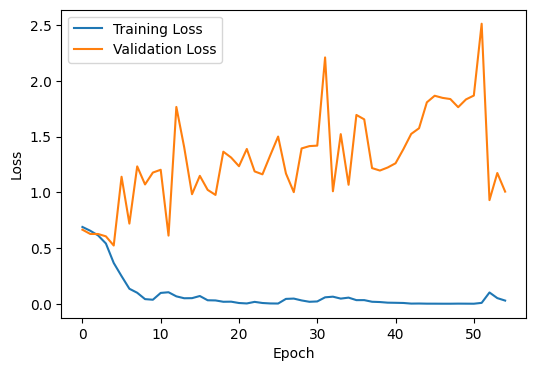

In [8]:
import torch
import matplotlib.pyplot as plt

def move_to_cpu(tensor):
    """Move a tensor to the CPU and convert it to a numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy()
    return tensor
    
def graph_results(train_losses, valid_losses):
    train_losses = [move_to_cpu(item) for item in train_losses]
    valid_losses = [move_to_cpu(item) for item in valid_losses]
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

graph_results(train_loss_list, val_loss_list)

# Test

Shape of all_predictions: torch.Size([195]), Unique values: [0 1]
Shape of all_actuals: torch.Size([195]), Unique values: [0 1]
Test Loss: 0.5518049171146674
              precision    recall  f1-score   support

           0     0.8092    0.8833    0.8446       120
           1     0.7812    0.6667    0.7194        75

    accuracy                         0.8000       195
   macro avg     0.7952    0.7750    0.7820       195
weighted avg     0.7984    0.8000    0.7965       195



<Figure size 800x600 with 0 Axes>

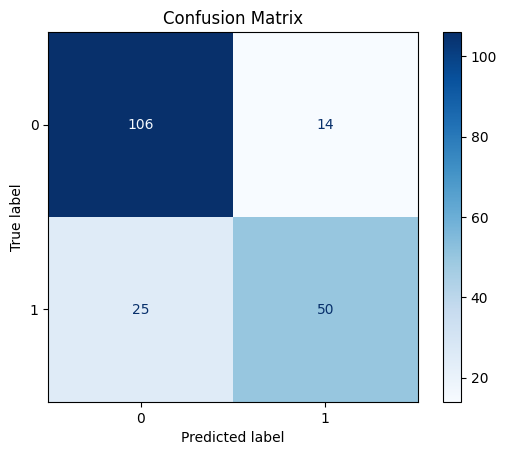

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
from sklearn.metrics import classification_report

best_model = model # 모델명 확인
best_model.load_state_dict(torch.load(r"C:\UnderGraduate\Deep Learning\DL_proj\checkpoint\CNN_LSTM.pth"), strict=False) # 파일명 확인
best_model.to(device)
best_model.eval()  # Set the model to evaluation mode

def plot_confusion_matrix(predictions, actuals, num_classes=2):
    cm = confusion_matrix(actuals, predictions, labels=range(num_classes))
    plt.figure(figsize=(8, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                display_labels=[i for i in range(num_classes)])
    cm_display.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


def test(model, device, test_loader, criterion=None):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.ndim == 4 and inputs.shape[1] == 1:
                inputs = inputs.squeeze(1)  # (B, 1, 16, 512) → (B, 16, 512)
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
            total += labels.size(0)
    avg_loss = running_loss / total if criterion is not None else None
    return torch.cat(all_preds), torch.cat(all_labels), avg_loss


criterion = nn.CrossEntropyLoss()
all_predictions, all_actuals, test_loss = test(best_model, device, test_loader, criterion)

y_pred = all_predictions.numpy()
y_true = all_actuals.numpy()

print(f"Shape of all_predictions: {all_predictions.shape}, Unique values: {np.unique(all_predictions.numpy())}")
print(f"Shape of all_actuals: {all_actuals.shape}, Unique values: {np.unique(all_actuals.numpy())}")
print("Test Loss:", test_loss)

print(classification_report(y_true, y_pred, digits=4))

plot_confusion_matrix(all_predictions.numpy(), all_actuals.numpy(), num_classes=2)

# Analysis

